In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [59]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

### ЗАДАЧА
Имеются данные по опробованию скважин с указанием содержания полезного компонента Fe и содержания сопутствующего полезного компонента Si.
Укрупненные интервалы опробования описаны геологом и определена геологическая порода LITH (задана кодом).<br>
Необходимо проанализировать исходные данные. Попробовать определить взаимосвязь зависимой переменной Fe от независимой переменной Si посредством построения регрессионной модели. Оценить возможное влияние категориальной переменной LITH на зависимые переменные Fe, Si
### РЕШЕНИЕ

Загрузим наши данные в датафреймы pandas

In [60]:
INPUT_FILE = "D:\Cloud\Git\geekbrains-theory-of-chances\coursework\data.xls"
#https://github.com/mmingalov/geekbrains-theory-of-chances/tree/master/coursework

SHEET_NAME_ASSAY = "assay"
SHEET_NAME_LITH = "lith"
df_assay = pd.read_excel(INPUT_FILE,sheet_name= SHEET_NAME_ASSAY)
df_lith = pd.read_excel(INPUT_FILE,sheet_name= SHEET_NAME_LITH)

__соберем единый датасет из двух исходных__
для этого выполним небольшую процедуру, которая проставит пробам соответсвующий интервалу опробования литологический код<br>
необходимость этого связана с тем, что геологические породы описаны по более укрупненным интервалам, и некоторые интервалы пород включают несколько проб

In [61]:
df_assay['lith'] = ""

N_assay = df_assay.shape[0]
for i in range(0,N_assay):
    assay_hole_id = df_assay.loc[i,"HOLE_ID"]
    assay_from = df_assay.loc[i,"FROM"]
    assay_to = df_assay.loc[i,"TO"]
    
    dfl = df_lith[df_lith["HOLE_ID"]==assay_hole_id].reset_index()
    N_lith = dfl.shape[0]
    
    for j in range(0,N_lith):
        lith_from = dfl.loc[j,"FROM"]
        lith_to = dfl.loc[j,"TO"]
        if(assay_from>=lith_from)&(assay_to<=lith_to):
            df_assay.loc[i,'lith']=dfl.loc[j,'LITH']
            break

In [62]:
df = df_assay
#df[df['T_Fe'].isnull()==False]

__Сейчас наш результирующий датасет включает всю информацию__

In [63]:
df.describe()

,FROM,TO,INT,T_Fe,SiO2
count,6568.000000,6568.000000,6568.000000,5561.000000,3156.000000
mean,325.402171,330.925942,5.523771,36.260504,12.024800
std,125.679376,122.296122,17.916386,15.605884,9.100951
min,0.000000,0.700000,0.340000,4.000000,0.015000
25%,252.235000,257.982500,1.910000,23.820000,4.107500
50%,336.015000,339.275000,2.000000,34.300000,10.900000
75%,411.147500,414.635000,2.940000,48.800000,18.202500
max,678.830000,739.040000,600.110000,70.060000,58.880000


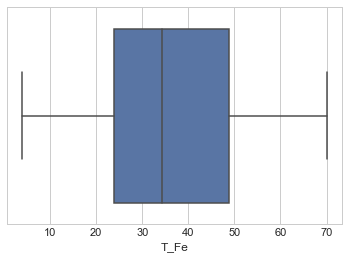

In [64]:
#pd.DataFrame(df["T_Fe"]).boxplot()
sns.boxplot(df["T_Fe"], orient='h')
plt.show()

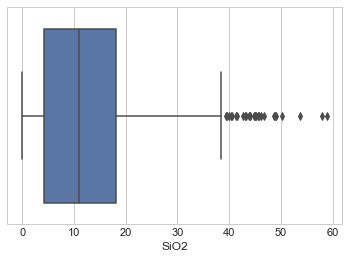

In [65]:
sns.boxplot(df["SiO2"], orient='h')
plt.show()

Проверим распределение наших перменных

C:\Users\mmingalov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mmingalov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


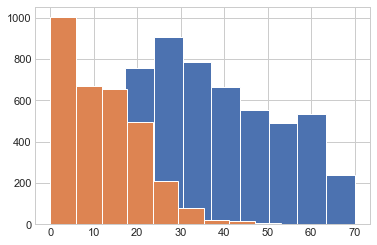

In [66]:
plt.hist(df['T_Fe']);
plt.hist(df['SiO2']);

проведем построение через альтернативный инструментарий

In [67]:
#откинем строки с пустыми содержаниями
df.loc[df['T_Fe'].isnull()==False, 'T_Fe']

2        8.31
3       35.88
4       39.73
5       51.89
6       46.38
        ...  
6557     9.20
6558    34.20
6559    21.38
6560     7.90
6561    11.00
Name: T_Fe, Length: 5561, dtype: float64

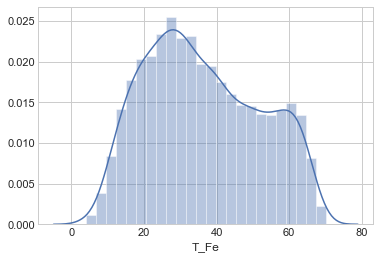

In [68]:
##откинем строки с пустыми содержаниями -- данные пробы не были опробованы лабораторией
sns.distplot(df.loc[df['T_Fe'].isnull()==False, 'T_Fe'])

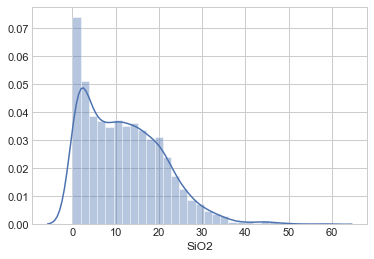

In [69]:
sns.distplot(df.loc[df['SiO2'].isnull()==False, 'SiO2'])

__распределение обоих переменных не походит на нормальное__

Попробуем определить корреляцию между содержаниями (Fe и Si). Для этого построим матрицу корреляций ВСЕХ количественных переменных в нашем наборе данных.

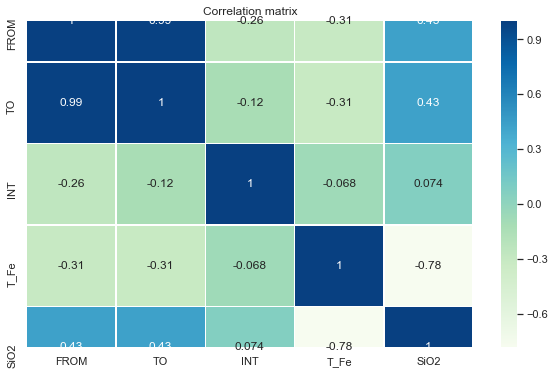

In [70]:
plt.figure(figsize = (10,6))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из знаний о предметной области мы понимаем, что содержание не зависит от параметров глубин интервала опробования и длины данного интервала. Однако Корреляция между Fe и Si, равная -0.78 имеет также и логический смысл, она говорит нам о наличии взаимосвязи между переменными.

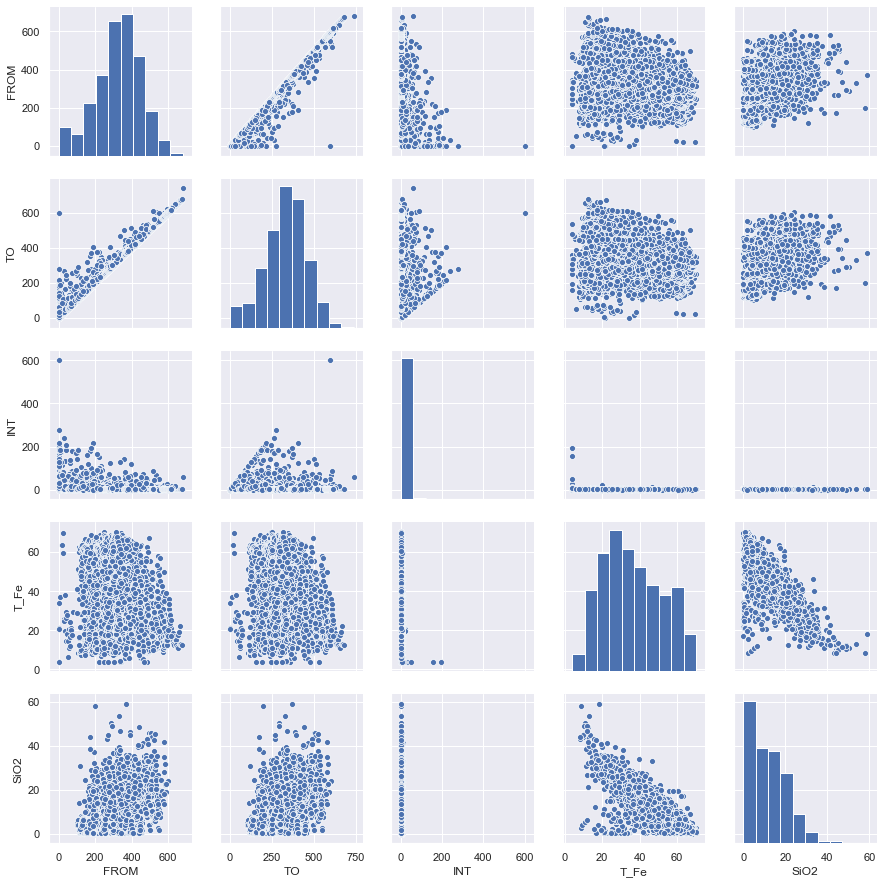

In [71]:
sns.pairplot(df)

Из всех вышеуказанных графиков нас будет интересовать именно T_Fe -- SiO2 <br>
Построим его ниже покрупнее, воспользовавшись другим инструментарием

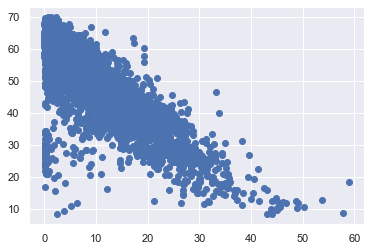

In [72]:
plt.scatter(df['SiO2'], df['T_Fe'])

График в общем виде походит на линейный. <br>
Коэффициент корреляции Пирсона r=-0.78, рассчитанный выше, так же говорит нам о наличии связи между переменными.

__Построим модель линейной регрессии__

в нашем наборе данных df не у всех проб проставлено содержание. Мы его не знаем. Вернее, мы не можем сказать точно по какой причине отсутствует значение -- либо оно ниже пределов обнаружения лабораторного метода, либо пробы вообще не анализировались лабораторией. Данные пропуски в идеале нужно обработать, чтобы строить модель. Но задать им значения НОЛЬ -- не выход. Более праивильно избаиться совсем от таких строк

In [73]:
len(df) - df.count()

HOLE_ID       0
FROM          0
TO            0
INT           0
T_Fe       1007
SiO2       3412
CODE       2980
lith        121
dtype: int64

In [74]:
#для построения модели будем брать только те строки
#x1 = np.array(df['SiO2'])
x1 = np.array(df.loc[((df['T_Fe'].isnull()==False) & (df['SiO2'].isnull()==False)), 'SiO2'])

#y1 = np.array(df['T_Fe'])
y1 = np.array(df.loc[((df['T_Fe'].isnull()==False) & (df['SiO2'].isnull()==False)), 'T_Fe'])

x1.shape[0], y1.shape[0]

(3156, 3156)

In [75]:
b1 = np.cov(x1, y1, ddof=0)[0, 1] / np.var(x1, ddof=0) 
#Замечание. В данной формуле не нужно обязательно использовать смещённую или несмещённую оценку, 
#но важно, конечно, использовать один и тот же тип оценки и для ковариации, и для дисперсии.
b1

-1.0780218576437075

In [76]:
b0 = y1.mean() - b1 * x1.mean()
b0

58.6832853002017

__Построим scatter plot по данным и отметим на нём прямую линейной регрессии__

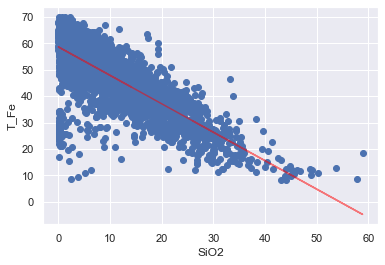

In [77]:
ox = x1
oy = b0 + b1 * ox

plt.scatter(x1, y1)
plt.plot(ox, oy, color='red', alpha=0.5)

plt.xlabel('SiO2')
plt.ylabel('T_Fe');

In [78]:
z1 = b0 + b1 * x1

np.vstack([y1, z1]).T[:5]

array([[35.88      , 43.48317711],
       [39.73      , 53.71360454],
       [51.89      , 57.27107667],
       [46.38      , 58.1011535 ],
       [62.75      , 58.65094464]])

In [79]:
#Коэффициент детерминации
R1 = 1 - (z1 - y1).var() / y1.var()
R1

0.6093092861801815

In [80]:
#Коэффициент корреляции
np.corrcoef(x1, y1)[0,1]

-0.7805826581344104

__средняя ошибка аппроксимации__ вычисляется по формуле:
$$\overline{A} = \frac{1}{n} \displaystyle\sum_{i=1}^{n} \Bigl| {{\frac{y_i - z_i}{y_i}} \Bigr|}.$$

Если $\overline{A}$ не превышает $8$-$10 \%$, можно сказать, что теоретические значения близки к тем, которые выдает модель линейной регрессии.

In [81]:
def mean_approximation_error(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Средняя ошибка аппроксимации.
    """
    
    return np.abs((y_real - y_pred) / y_real).mean()

In [82]:
mean_approximation_error(y1, z1)

0.15132841526349844

Наша __средняя ошибка аппроксимации__ превышает 10%, что говорит о том, что теоретические значения недостаточно близки к тем, которые выдет модель линейной регрессии

__ВЫВОД:__ тем не менее из значений коэффициентов корреляции и детерминации можно сделать вывод о том, что есть связь между содержаниями SiO2 и T_Fe. Присутствие SiO2 в пробе может указаывать нам на определенное содержание T_Fe в данном интервале опробования.

### Обзор категориальной переменной
выявим множество значений категориальной переменной LITH, получив его из проб с непустыми содержаниями по T_Fe и SiO2 

In [83]:
df[(df['SiO2']>0)&(df['T_Fe']>0)]['lith'].value_counts()


BMt    1117
DMt     649
DHe     586
SMt     131
BHe     109
GMt     105
GdP      83
GHe      80
SHe      73
Ssr      64
BPy      31
Pan      22
Dsr      13
Dpy      12
Tub       8
Bsr       6
GPy       5
Gsr       5
Aaa       5
SQz       4
Tuu       4
Sik       3
Bre       3
Fhe       3
San       2
Spy       1
Ehe       1
GNt       1
Lll       1
Ssg       1
Dgp       1
Name: lith, dtype: int64

In [84]:
df2 = df[(df['SiO2']>0)&(df['T_Fe']>0)]
df2

,HOLE_ID,FROM,TO,INT,T_Fe,SiO2,CODE,lith
3,DDH1,109.79,114.29,4.50,35.88,14.10,m1,DMt
4,DDH1,114.29,117.22,2.93,39.73,4.61,m1,GMt
5,DDH1,117.22,120.80,3.58,51.89,1.31,m1,GMt
6,DDH1,120.80,123.71,2.91,46.38,0.54,m1,GMt
7,DDH1,123.71,128.63,4.92,62.75,0.03,m1,BMt
...,...,...,...,...,...,...,...,...
6476,RCH84,542.36,544.36,2.00,36.32,13.51,NaN,DHe
6477,RCH84,544.36,546.71,2.35,32.35,8.69,NaN,DHe
6478,RCH84,546.71,548.71,2.00,20.65,2.61,NaN,GdP
6479,RCH84,548.71,550.00,1.29,19.60,1.84,NaN,GdP


### Задача: 
Через однофакторный дисперсионный анализ исследуем влияние LITH на целевую переменную T_Fe. Сформулируем гипотезу $H_{0}$  -- "фактор LITH не влияет на значение содержания T_fe"
### Решение

Проведем однофакторный дисперсионный анализ. <br>Переменная будет иметь k групп -- по числу уникальных кодов из множества значений фактора LITH

In [108]:
df2 = df[(df['SiO2']>0)&(df['T_Fe']>0)&(df['lith'].isnull()==False)]
df2

,HOLE_ID,FROM,TO,INT,T_Fe,SiO2,CODE,lith
3,DDH1,109.79,114.29,4.50,35.88,14.10,m1,DMt
4,DDH1,114.29,117.22,2.93,39.73,4.61,m1,GMt
5,DDH1,117.22,120.80,3.58,51.89,1.31,m1,GMt
6,DDH1,120.80,123.71,2.91,46.38,0.54,m1,GMt
7,DDH1,123.71,128.63,4.92,62.75,0.03,m1,BMt
...,...,...,...,...,...,...,...,...
6476,RCH84,542.36,544.36,2.00,36.32,13.51,NaN,DHe
6477,RCH84,544.36,546.71,2.35,32.35,8.69,NaN,DHe
6478,RCH84,546.71,548.71,2.00,20.65,2.61,NaN,GdP
6479,RCH84,548.71,550.00,1.29,19.60,1.84,NaN,GdP


In [109]:
#проверим на пропуски
len(df2) - df2.count()

HOLE_ID      0
FROM         0
TO           0
INT          0
T_Fe         0
SiO2         0
CODE       499
lith         0
dtype: int64

In [110]:
unique_k = df2['lith'].unique() #список
n=df2.shape[0]
k = len(unique_k)
print(unique_k)
print("Всего k:",k)
print("Всего n:",n)

['DMt' 'GMt' 'BMt' 'GdP' 'Pan' 'Sik' 'GNt' 'Dgp' 'DHe' 'GHe' 'BPy' 'SMt'
 'SHe' 'Aaa' 'Tuu' 'SQz' 'Dpy' 'BHe' 'Bsr' 'Bre' 'Gsr' 'Dsr' 'Spy' 'Ehe'
 'Fhe' 'Ssr' 'Ssg' 'GPy' 'Lll' 'San' 'Tub']
Всего k: 31
Всего n: 3129


In [111]:
dict_list=[] #список k элементов
for i in range(len(unique_k)):
    code = unique_k[i]
    dict_list.append({
        "LITH": code,
        "X":np.array(df2.loc[df2["lith"]==code,"SiO2"]),
        "Y":np.array(df2.loc[df2["lith"]==code,"T_Fe"]),
        "N":df2.loc[df2["lith"]==code,"T_Fe"].shape[0],
        "Y_mean":np.mean(np.array(df2.loc[df2["lith"]==code,"T_Fe"]))
        
    })

#проверим средние в наших группах
for i in dict_list:
    print(i["LITH"],i["Y_mean"])
#dict_list[0]

DMt 39.28231124807396
GMt 45.707047619047614
BMt 56.991799462846906
GdP 18.477710843373494
Pan 18.083636363636362
Sik 17.826666666666664
GNt 53.38
Dgp 14.02
DHe 38.834436860068266
GHe 43.508625
BPy 46.6358064516129
SMt 44.66732824427481
SHe 44.75794520547945
Aaa 18.880000000000003
Tuu 21.8975
SQz 12.87
Dpy 30.46083333333333
BHe 52.952568807339446
Bsr 37.35
Bre 15.433333333333332
Gsr 32.86
Dsr 37.88923076923077
Spy 41.08
Ehe 35.95
Fhe 32.81666666666667
Ssr 38.36046875
Ssg 34.3
GPy 36.589999999999996
Lll 23.5
San 15.925
Tub 15.65625


Видно, что средние содержания разнятся. Установим, что это отличие статистически значимо. Для этого сначала соберем
все значения содержаний в один массив:

In [112]:
#можно взять отсюда
y_all = df2['T_Fe']
y_all

3       35.88
4       39.73
5       51.89
6       46.38
7       62.75
        ...  
6476    36.32
6477    32.35
6478    20.65
6479    19.60
6558    34.20
Name: T_Fe, Length: 3129, dtype: float64

In [113]:
#найдем среднее значение по всем содержаниям
y_mean = np.mean(y_all)
print(y_mean)

45.74441994247369


Найдем $S^2$ — сумму квадратов отклонений наблюдений от общего среднего:

In [124]:
s2 = np.sum((y_all - y_mean)**2)
s2

496712.84217219555

Найдём значения $S_b^2$ и $S_w^2$:

In [117]:
S2_b =0
for i in range(k):
    ni = dict_list[i]["N"]
    yi_mean = dict_list[i]["Y_mean"]
    #print(i,ni,yi_mean)
    S2_b = S2_b + ni * (yi_mean - y_mean) ** 2
    
print('S2_b:',S2_b)

#S2_b, S2_w

S2_b: 316635.6510095101


In [118]:
S2_w = 0
for i in range(k):
    yi_mean = dict_list[i]["Y_mean"]
    #print(i,ni,yi_mean)
    S2_w = S2_w + ((dict_list[i]["Y"] - yi_mean) ** 2).sum()
    
print('S2_w:',S2_w)

S2_w: 180077.19116268534


Удостоверимся, что соблюдается равенство $S^2 = S_{b}^2 + S_{w}^2$:

In [126]:
print(s2)
print(S2_b + S2_w)

496712.84217219555
496712.84217219544


Запишем оценки дисперсий

In [119]:
k1 = k - 1
k2 = n - k

sigma2_b = S2_b / k1
sigma2_w = S2_w / k2

sigma2_b, sigma2_w

(10554.521700317004, 58.12691774134453)

Итак, значение статистики $F$:

In [121]:
F = sigma2_b / sigma2_w
F

181.57717818933622

Зафиксируем уровень значимости $\alpha = 0.05$. Для него найдём критическое значение $F_{crit}$:

In [122]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

1.462812083913991

Видим, что $F > F_{crit}$, поэтому заключаем, что отличие средних содержаний действительно является статистически значимым.
Нашу гипотезу отвергаем.
Делаем вывод, что lith оказывает влияние на целевую переменную T_Fe